# Import libraries

In [1]:
# Fix randomness and hide warnings
RND = True
if not RND:
    seed = 76998669

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if not RND:
    os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
if not RND:
    np.random.seed(seed)

import logging

import random
if not RND:
    random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras.preprocessing.image import ImageDataGenerator

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
if not RND:
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [4]:
# download clean dataset
!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz

# load dataset
dataset = np.load('public_data_clean.npz', allow_pickle=True)
keys = list(dataset.keys())
images = np.array(dataset[keys[0]])
labels = np.array(dataset[keys[1]])

labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])


--2023-11-07 20:03:46--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 536546306 (512M) [application/octet-stream]
Saving to: ‘public_data_clean.npz’

public_data_clean.n 100%[===================>] 511.69M  25.0MB/s    in 21s     

2023-11-07 20:04:09 (23.8 MB/s) - ‘public_data_clean.npz’ saved [536546306/536546306]



In [5]:
import functools

def augment_data(X,y,new_images):
  datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,)

  gen_images = new_images # Number of images that has to be generated
  for img in datagen.flow(X,y,batch_size = 1):
    if gen_images <= 0:
      break
    gen_images -= 1
    X = np.insert(X,0,img[0][0],axis=0)
    y = np.insert(y,0,img[1][0],axis=0)

  return X,y

# we are assuming positives are more than negatives and we want to equal the number of the two classes
def balance_sets(images,labels):
    negative_n = functools.reduce(lambda a, b: a+b, labels)
    print(negative_n)
    positive_n = len(images) - negative_n
    print(positive_n)
    to_add = int((positive_n - negative_n)/2)
    to_delete = to_add
    X_n = images[labels == 1]
    y_n = labels[labels == 1]
    deletable = []
    for i in range(0,to_delete):
      to_delete -= 1
      el = random.randrange(0,len(labels))
      while(labels[el] == 1 or el in deletable):
        el = random.randrange(0,len(labels))
      deletable.append(el)

    images = np.delete(images, deletable, axis=0)
    labels = np.delete(labels, deletable, axis=0)

    for i in range(0,to_add):
      to_add -= 1
      el = random.randrange(0,negative_n - 1)
      images = np.insert(images,0,X_n[el],axis=0)
      labels = np.insert(labels,0,1,axis=0)
      if to_add <= 0:
         break

    print(functools.reduce(lambda a, b: a+b, labels))
    print(len(images) - negative_n)
    return images,labels

images, labels = balance_sets(images,labels)

1790
3060
2425
3060


In [6]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size = int(0.05 * len(images)),
    **({"random_state":seed} if not RND else {}),
    stratify = labels
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = int(0.15 * len(images)),
    **({"random_state":seed} if not RND else {}),
    stratify = y_train_val
)

#X_train, y_train = augment_data(X_train,y_train,3000)

## Split data

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

gen_images = 4000 # Number of images that has to be generated
for img in datagen.flow(X_train,y_train,batch_size = 1):
  if gen_images <= 0:
    break
  gen_images -= 1
  X_train = np.insert(X_train,0,img[0][0],axis=0)
  y_train = np.insert(y_train,0,img[1][0],axis=0)


## Inspect data

## Process data

In [7]:
# Normalize data to the range [0, 1]
X_train = X_train.astype("float32")/255.
X_val = X_val.astype("float32")/255.
X_test = X_test.astype("float32")/255.

In [8]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model


# Model

## Build model

In [9]:
from keras.applications.mobilenet import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  preprocessing = tfk.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(-0.7,0.7)),
        tfkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
        #tfkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
        tfkl.RandomFlip('horizontal'),
        tfkl.RandomFlip('vertical'),
        tf.keras.layers.RandomRotation(factor=(0,0.25)),
    ], name='preprocessing')

  res = tfk.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )

  res.trainable = False
  input_layer = tfkl.Input(input_shape)
  x = preprocess_input(input_layer)

  x = preprocessing(x)

  x = res(x)
  x = tfkl.GlobalAveragePooling2D()(x)

  x = tfkl.Dense(units=1024,activation=tfkl.LeakyReLU(alpha=0.3))(x) #maybe we have to use leakyrelu
  # x = tfkl.Dense(units=256,activation='relu')(x)

  output_layer = tfkl.Dense(units=output_shape,activation='softmax')(x)

  model =tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

  return model

model = apple_elixir_model(input_shape,output_shape)


9406464/9406464 [==============================] - 0s 0us/step


In [10]:
# Train the model

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7            # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = model.fit(
    x = X_train*255, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 300,
    validation_data = (X_val*255, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks
).history

Epoch 1/300
122/122 [==============================] - 18s 45ms/step - loss: 0.7604 - accuracy: 0.6787 - val_loss: 0.5751 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 2/300
122/122 [==============================] - 3s 21ms/step - loss: 0.5706 - accuracy: 0.7199 - val_loss: 0.4863 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 3/300
122/122 [==============================] - 3s 21ms/step - loss: 0.5466 - accuracy: 0.7274 - val_loss: 0.4959 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 4/300
122/122 [==============================] - 3s 24ms/step - loss: 0.5257 - accuracy: 0.7398 - val_loss: 0.5066 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 5/300
122/122 [==============================] - 3s 23ms/step - loss: 0.5191 - accuracy: 0.7431 - val_loss: 0.4750 - val_accuracy: 0.7648 - lr: 0.0010
Epoch 6/300
122/122 [==============================] - 2s 20ms/step - loss: 0.5097 - accuracy: 0.7454 - val_loss: 0.4749 - val_accuracy: 0.7717 - lr: 0.0010
Epoch 7/300
122/122 [==============================] - 2s

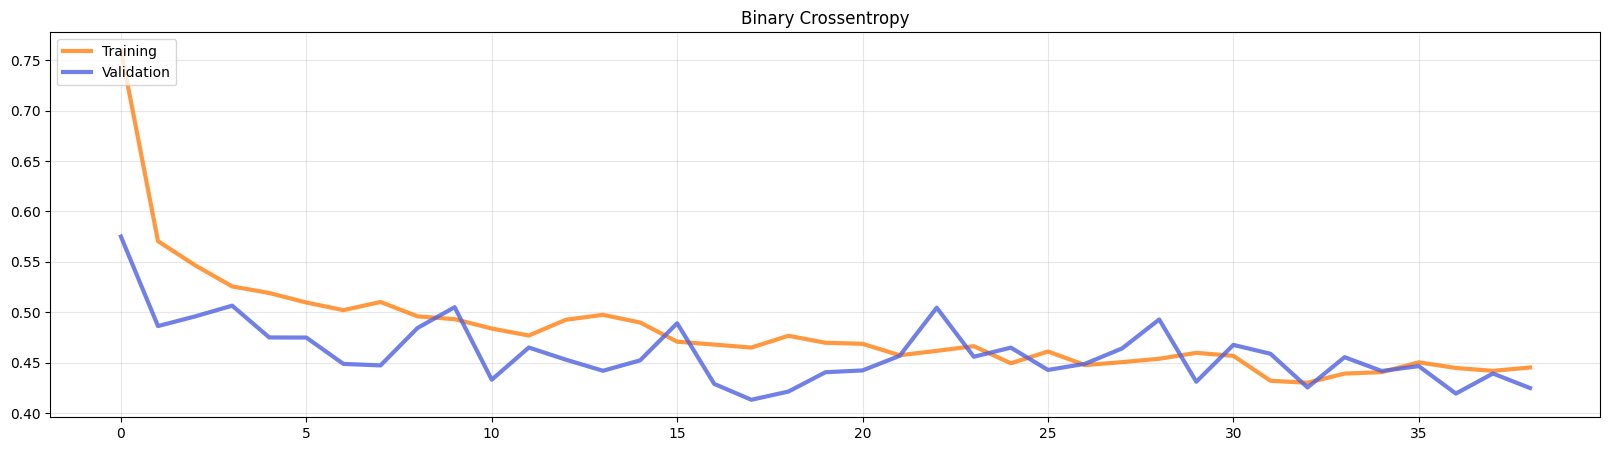

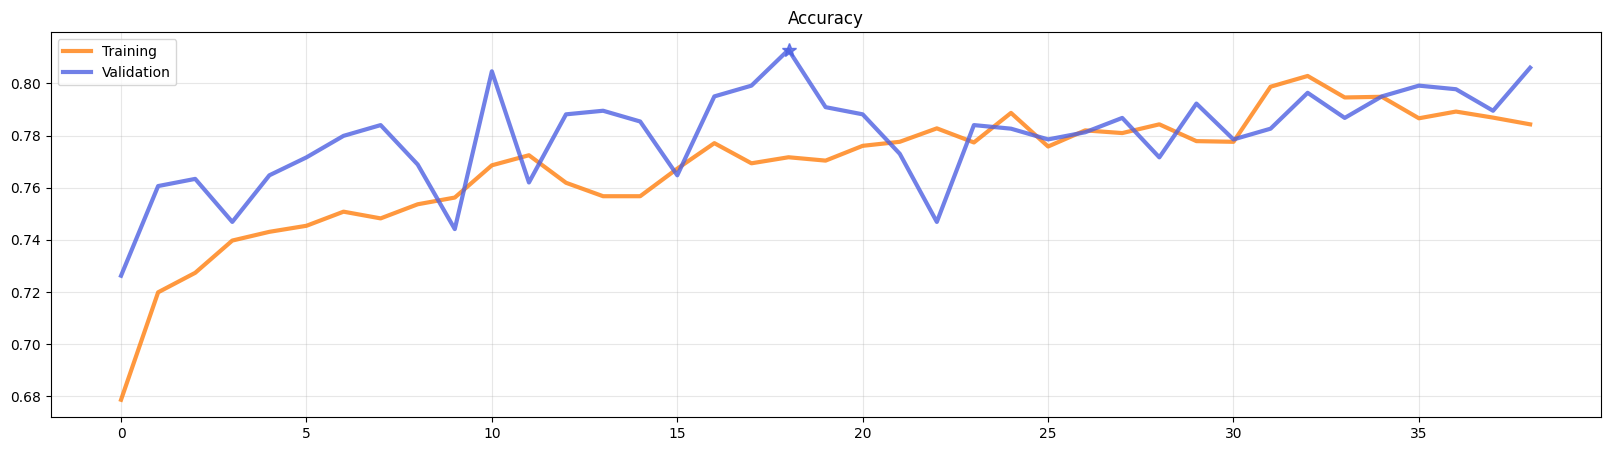

Accuracy Score over the Test Set: 0.7934



In [11]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

test_predictions = model.predict(X_test*255, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy: 0.7934
Precision: 0.7963
Recall: 0.7934
F1: 0.7929


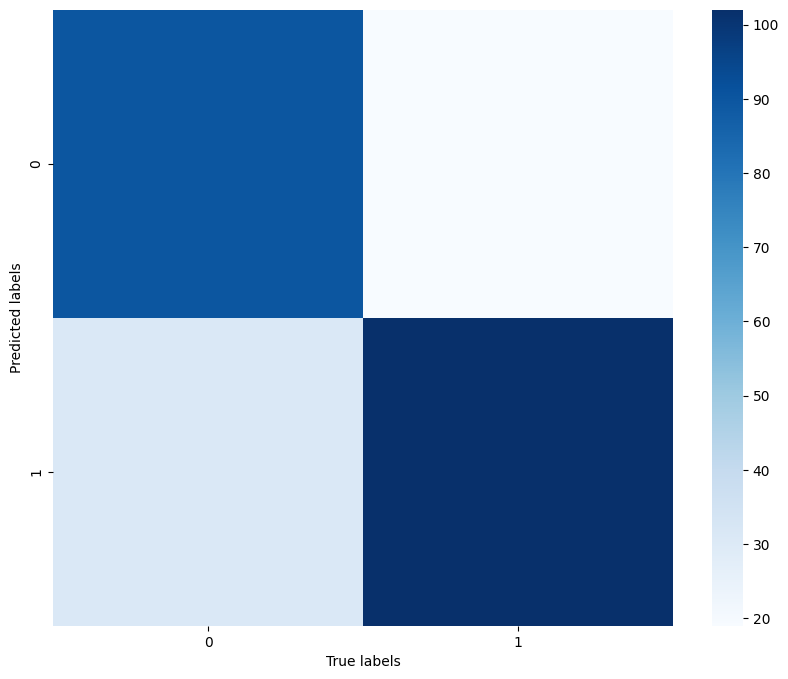

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
# Compute the confusion matrix
test_predictions = model.predict(X_test*255, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## Train model

In [28]:
model.save('PreTrained')

KeyboardInterrupt: ignored

In [29]:
ft_model = tfk.models.load_model('PreTrained')

ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
c = 0
for i, layer in enumerate(model.get_layer('mobilenetv2_1.00_96').layers):
   c += 1

print(c)
#769 layers in NASNet

154


In [30]:
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:80]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

In [31]:

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7            # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = ft_model.fit(
    x = X_train*255, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 300,
    validation_data = (X_val*255, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks
).history

Epoch 1/300
122/122 [==============================] - 32s 66ms/step - loss: 0.5743 - accuracy: 0.7124 - val_loss: 1.4018 - val_accuracy: 0.6589 - lr: 0.0010
Epoch 2/300
122/122 [==============================] - 6s 47ms/step - loss: 0.4951 - accuracy: 0.7650 - val_loss: 1.1197 - val_accuracy: 0.7084 - lr: 0.0010
Epoch 3/300
122/122 [==============================] - 6s 50ms/step - loss: 0.4602 - accuracy: 0.7877 - val_loss: 2.9912 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 4/300
122/122 [==============================] - 6s 49ms/step - loss: 0.4523 - accuracy: 0.7910 - val_loss: 1.4389 - val_accuracy: 0.7153 - lr: 0.0010
Epoch 5/300
122/122 [==============================] - 6s 48ms/step - loss: 0.4376 - accuracy: 0.7990 - val_loss: 0.5870 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 6/300
122/122 [==============================] - 6s 51ms/step - loss: 0.4272 - accuracy: 0.8011 - val_loss: 1.2517 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 7/300
122/122 [==============================] - 6s

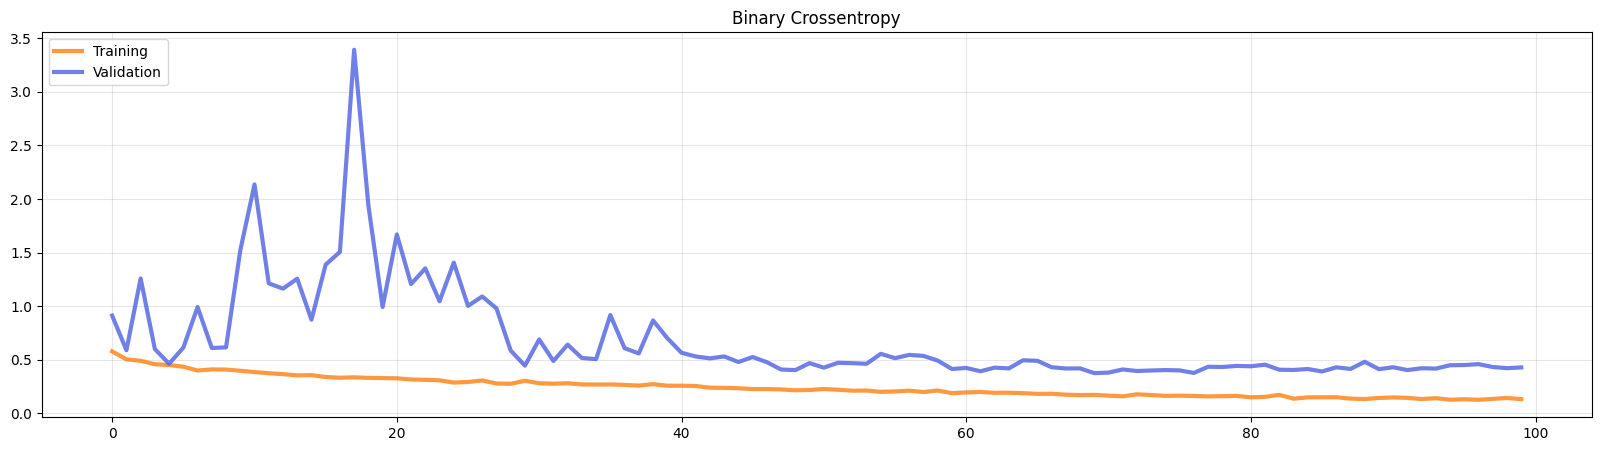

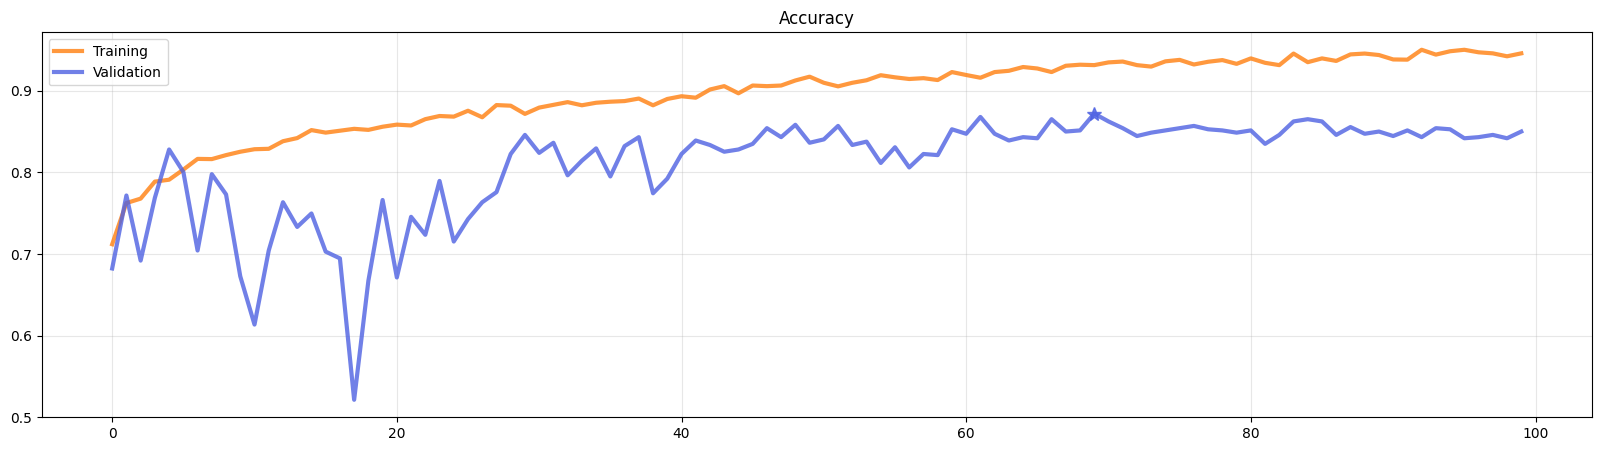

Accuracy Score over the Test Set: 0.7934



In [25]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

test_predictions = model.predict(X_test*255, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

Accuracy: 0.7934
Precision: 0.7963
Recall: 0.7934
F1: 0.7929


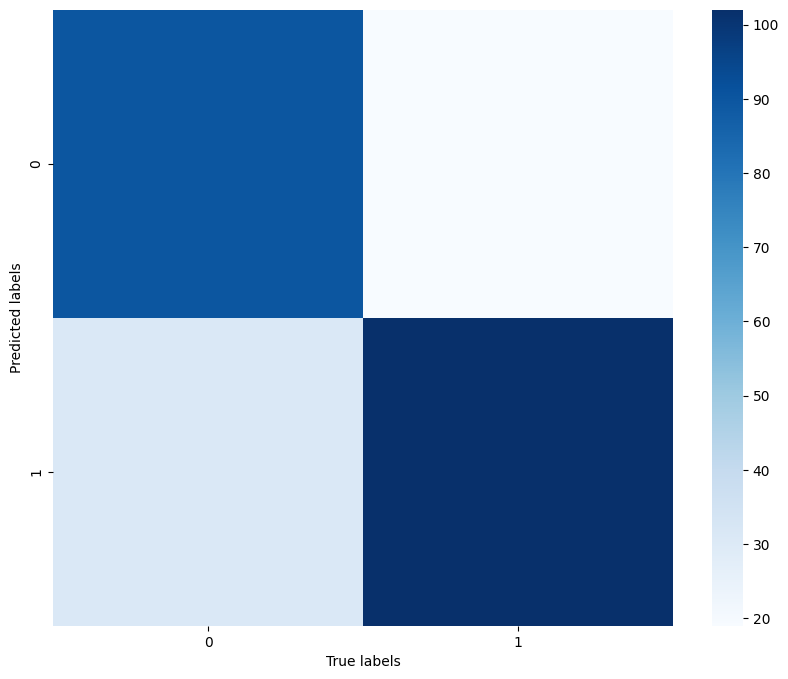

In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
# Compute the confusion matrix
test_predictions = model.predict(X_test*255, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [27]:
model.save('PreTrained')

In [20]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

model.save('/gdrive/My Drive/Transf_MobileNetV2_MM')

Mounted at /gdrive
/gdrive/My Drive




> larger filters

> adam optimizer


> scheduled learning rate in training seems to be effective


> lot of augmentation



> residual learning seems to be effective